# Fresh take

## 1. Initalize sites

In [65]:
import os
dpth = r'G:\My Drive\FileDump\SCL_Testing\raw'
dpth = r'U:\EC_Backup\SCL_Data\20240912'


fl = os.listdir(dpth)
fl.sort()
print(fl)

['Flux_Data1000.dat', 'Flux_Data1001.dat', 'Flux_Data1002.dat', 'Flux_Data1003.dat', 'Flux_Data1004.dat', 'Flux_Data1005.dat', 'Flux_Data1006.dat', 'Flux_Data1007.dat', 'Flux_Data1008.dat', 'Flux_Data1009.dat', 'Flux_Data1010.dat', 'Flux_Data1011.dat', 'Flux_Data1012.dat', 'Flux_Data1013.dat', 'Flux_Data1014.dat', 'Flux_Data1015.dat', 'Flux_Data1016.dat', 'Flux_Data1017.dat', 'Flux_Data1018.dat', 'Flux_Data1019.dat', 'Flux_Data1020.dat', 'Flux_Data1021.dat', 'Flux_Data1022.dat', 'Flux_Data1023.dat', 'Flux_Data1024.dat', 'Flux_Data1025.dat', 'Flux_Data1026.dat', 'Flux_Data1027.dat', 'Flux_Data1028.dat', 'Flux_Data1029.dat', 'Flux_Data1030.dat', 'Flux_Data1031.dat', 'Flux_Data1032.dat', 'Flux_Data1033.dat', 'Flux_Data1034.dat', 'Flux_Data1035.dat', 'Flux_Data1036.dat', 'Flux_Data1037.dat', 'Flux_Data1038.dat', 'Flux_Data1039.dat', 'Flux_Data1040.dat', 'Flux_Data1041.dat', 'Flux_Data1042.dat', 'Flux_Data1043.dat', 'Flux_Data1044.dat', 'Flux_Data1045.dat', 'Flux_Data1046.dat', 'Flux_Data10

In [ ]:
import matplotlib.pyplot as plt

from parseFiles import parseCSI,baseMethods
import importlib
importlib.reload(parseCSI)
importlib.reload(baseMethods)
import os
TOB3 = r'parseFiles\example_data\Flux_Data640.dat'
outputPath = r'G:\My Drive\FileDump\SCL_Testing\intermediate'
# f = parseCSI.parseTOB3(sourceFile=TOB3,dropCols=['Diagnostic_CSAT'])
# tmp = baseMethods.binBundle(variableMap=f.variableMap,DataFrame=f.DataFrame,filename=f.fileTimestamp,outputPath=outputPath)
t = []
r = []
import time
for f in fl:
    if f.endswith('.dat'):
        t1 = time.time()
        TOB3 = os.path.join(dpth,f)
        f = parseCSI.parseTOB3(sourceFile=TOB3,dropCols=['Diagnostic_CSAT'])
        tmp = baseMethods.binBundle(variableMap=f.variableMap,DataFrame=f.DataFrame,filename=f.fileTimestamp,outputPath=outputPath,verbose=False)
        t.append(f.DataFrame.index[0])
        print((f.fileTimestamp))
        diag_codes = (tmp.DataFrame[['Diagnostic_7700','RSSI']].groupby('Diagnostic_7700').agg(['count','mean']))
        # subset = diag.copy()
        r.append(tmp.DataFrame['RSSI'].median())
        print((tmp.DataFrame['RSSI'].median()))
        print(time.time()-t1)
        print()
plt.figure()
plt.scatter(t,r)

2024_08_05_0730
28.263099670410156
2.367776393890381

2024_08_05_0800
26.809099197387695
2.3110709190368652

2024_08_05_0830
46.062198638916016
2.285993814468384

2024_08_05_0900
46.180850982666016
2.2846105098724365

2024_08_05_0930
45.64360046386719
2.3073692321777344

2024_08_05_1000
45.24409866333008
2.3398420810699463

2024_08_05_1030
43.748600006103516
3.0521984100341797

2024_08_05_1100
44.15639877319336
2.272536039352417

2024_08_05_1130
44.04719924926758
2.2611520290374756

2024_08_05_1200
43.18199920654297
2.891587734222412

2024_08_05_1230
42.255001068115234
2.8040366172790527

2024_08_05_1300
42.18754959106445
2.2716245651245117

2024_08_05_1330
42.620601654052734
2.866882801055908

2024_08_05_1400
43.55350112915039
2.920485019683838



In [71]:
2510*1.7/60

71.11666666666666

Index(['Ux', 'Uy', 'Uz', 'Ts', 'Diagnostic_CSAT', 'CO2', 'H2O', 'press',
       'LI7500_diag', 'LI7550_SignalStrength', 'seconds', 'nanoseconds',
       'Diagnostic_7700', 'CH4_density', 'CH4_mole_fraction', 'Temperature',
       'Pressure', 'RSSI'],
      dtype='object')


<Axes: xlabel='TIMESTAMP'>

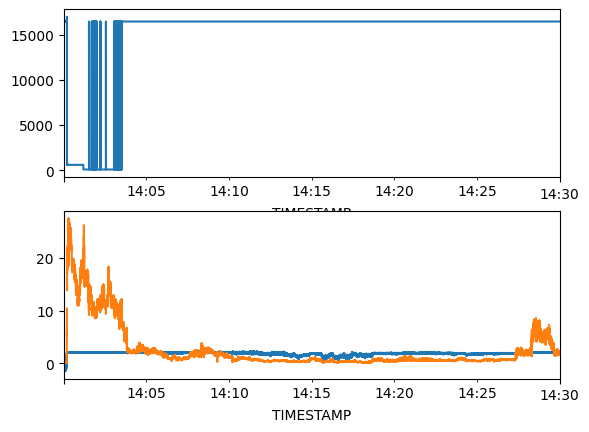

In [ ]:
print(tmp.DataFrame.columns)
fig,ax=plt.subplots(2)
tmp.DataFrame['Diagnostic_7700'].plot(ax=ax[0])
tmp.DataFrame['CH4_mole_fraction'].plot(ax=ax[1])
tmp.DataFrame['RSSI'].plot(ax=ax[1])

In [8]:
import numpy as np
import pandas as pd


f = r"\\wsl.localhost\Ubuntu\home\jskeeter\FluxCalc_engine\custom\binData\2024_07_28_1930.float32_array"
print(f)
float32_array = np.fromfile(f,dtype='float32')
print(float32_array.shape)
fn = f'{tmp.filename}.ecf32'
f = os.path.join(tmp.outputPath,fn)
print(f)
ecf32 = np.fromfile(f,dtype='float32')
print(ecf32.shape)
# pd.to_datetime(np.fromfile('2024_07_28_1430.POSIX_timestamp'),unit='s')

\\wsl.localhost\Ubuntu\home\jskeeter\FluxCalc_engine\custom\binData\2024_07_28_1930.float32_array
(540000,)
G:\My Drive\FileDump\SCL_Testing\intermediate\2024_07_28_1930.ecf32
(540000,)


In [76]:

fn = f'{tmp.filename}.tsf64'
f = os.path.join(tmp.outputPath,fn)
print(f)
tsf64 = np.fromfile(f,dtype='float64')
print(ecf32.reshape(tsf64.shape[0],-1).shape)
print(float32_array.reshape(tsf64.shape[0],-1).shape)

G:\My Drive\FileDump\SCL_Testing\intermediate\2024_07_28_1930.tsf64
(36000, 16)
(36000, 15)


In [1]:
from parseFiles import parseCSV
import pandas as pd
sf = r'example_data\20240914\20750528-SHSC.SSM.SGT.240720_240913readout.csv'
import importlib
importlib.reload(parseCSV)
f = parseCSV.hoboCSV(sourceFile=sf,skiprows=1)
print(f.variableMap)
f.DataFrame.head()

{'_': {'originalName': '#', 'ignore': True, 'instrument': None, 'unit': None, 'dtype': '<i8', 'frequency': None, 'variableDescription': None}, 'Date_Time_GMT_00_00': {'originalName': 'Date Time, GMT+00:00', 'ignore': True, 'instrument': None, 'unit': None, 'dtype': '|O', 'frequency': None, 'variableDescription': None}, 'Temp_C_LGR_S_N_20750528_SEN_S_N_20750528_LBL_5_': {'originalName': 'Temp, °C (LGR S/N: 20750528, SEN S/N: 20750528, LBL: 5)', 'ignore': False, 'instrument': None, 'unit': None, 'dtype': '<f8', 'frequency': None, 'variableDescription': None}, 'Temp_C_LGR_S_N_20750528_SEN_S_N_20750528_LBL_25_': {'originalName': 'Temp, °C (LGR S/N: 20750528, SEN S/N: 20750528, LBL: 25)', 'ignore': False, 'instrument': None, 'unit': None, 'dtype': '<f8', 'frequency': None, 'variableDescription': None}, 'Temp_C_LGR_S_N_20750528_SEN_S_N_20750528_LBL_50_': {'originalName': 'Temp, °C (LGR S/N: 20750528, SEN S/N: 20750528, LBL: 50)', 'ignore': False, 'instrument': None, 'unit': None, 'dtype': '<

,_,Date_Time_GMT_00_00,Temp_C_LGR_S_N_20750528_SEN_S_N_20750528_LBL_5_,Temp_C_LGR_S_N_20750528_SEN_S_N_20750528_LBL_25_,Temp_C_LGR_S_N_20750528_SEN_S_N_20750528_LBL_50_,Temp_C_LGR_S_N_20750528_SEN_S_N_20750528_LBL_100_,Host_Connected_LGR_S_N_20750528_,Stopped_LGR_S_N_20750528_,End_Of_File_LGR_S_N_20750528_
"Date Time, GMT+00:00",,,,,,,,,
2024-07-20 21:00:00,1,24/07/20 21:00:00,11.589,2.557,-0.311,-1.584,NaN,NaN,NaN
2024-07-20 21:30:00,2,24/07/20 21:30:00,11.759,2.503,-0.311,-1.584,NaN,NaN,NaN
2024-07-20 22:00:00,3,24/07/20 22:00:00,11.977,2.477,-0.311,-1.584,NaN,NaN,NaN
2024-07-20 22:30:00,4,24/07/20 22:30:00,12.074,2.477,-0.339,-1.584,NaN,NaN,NaN
2024-07-20 23:00:00,5,24/07/20 23:00:00,12.147,2.477,-0.339,-1.584,NaN,NaN,NaN


In [3]:

from parseFiles import baseMethods
importlib.reload(baseMethods)
from dataclasses import dataclass, field
import numpy as np
import sys

@dataclass(kw_only=True)
class parseDEF(baseMethods.genericLoggerFile):
    defFile: str
    defTimestamp: str = None
    programName: str = None
    LoggerModel: str = None
    DEF: list = field(default_factory=lambda:[])
    Arrays: dict = field(default_factory=lambda:{})
    # variableMap: dict = field(default_factory=lambda:{})
    
    def __post_init__(self):
        with open(self.defFile,'r',encoding='utf-8-sig') as f:
            self.DEF = f.readlines()
            
        arrID = '-1'
        for i,l in enumerate(self.DEF):
            if i == 0:
                self.defTimestamp  = l.rstrip()
            elif i == 1:
                self.defTimestamp = self.defTimestamp + ' ' + l.rstrip()
                self.defTimestamp = pd.to_datetime(self.defTimestamp,format='%m/%d/%Y %H:%M:%S').strftime(format=self.__dataclass_fields__['fileTimestamp'].default)
            k = 'Program:'
            if k in l:
                self.programName = l.split(k)[-1].rstrip('-\n').lstrip()
            k = 'Wiring for'
            if k in l:
                self.LoggerModel = l.split(k)[-1].rstrip('-\n').lstrip()
            if 'Output_Table' in l:
                l = l.rstrip('-\n').replace('  ',' ').split(' ')
                arrID = l[0]
                frequency = pd.to_timedelta(self.parseFreq(f"{l[2]} {l[3]}")).total_seconds()
                self.Arrays[arrID] = {}
                self.Arrays[arrID]['variableMap'] = {}
                self.Arrays[arrID]['DataFrame'] = []
                self.Arrays[arrID]['Frequency'] = str(frequency)+'s'
            elif arrID != '-1' and l == '\n':
                arrID = '-1'
            elif arrID != '-1' :
                l = l.rstrip('\n').split(' ')
                operation = 'Smp'
                if l[0] == '1':
                    name = 'ArrayID'
                    dataType = 'int32'
                else:
                    name = l[1]
                    if len(name.split('_'))>1:
                        operation = name.split('_')[-1]
                    if operation == 'RTM':
                        dataType = 'int32'
                    else:
                        dataType = 'float32'
                self.Arrays[arrID]['variableMap'][name] = {}
                self.Arrays[arrID]['variableMap'][name]['operation'] = operation
                self.Arrays[arrID]['variableMap'][name]['dataType'] = dataType
                self.Arrays[arrID]['variableMap'][name]['ignore'] = dataType == 'float32'
                
@dataclass(kw_only=True)
class parseMixedArray(parseDEF):
    sourceFile: str
    
    def __post_init__(self):
        with open(self.sourceFile) as file:
            MA = [l.rstrip('\n').split(',') for l in file.readlines()]
        super().__post_init__()
        for i,row in enumerate(MA):
            if len(row) == len(self.Arrays[row[0]]['variableMap']):
                self.Arrays[row[0]]['DataFrame'].append(row[1:])
            else:
                if self.verbose:print(f'row {i} length does not match {self.defFile}')
        for arrID in self.Arrays:
            self.Arrays[arrID]['DataFrame'] = pd.DataFrame(self.Arrays[arrID]['DataFrame'],
                                                           columns=list(self.Arrays[arrID]['variableMap'].keys())[1:])
            na_value=['6999','-6999']
            for val in na_value:
                self.Arrays[arrID]['DataFrame'] = self.Arrays[arrID]['DataFrame'].replace(val,np.nan)
            dtCols = ['Year_RTM', 'Day_RTM', 'Hour_Minute_RTM']
            if not sum([c in self.Arrays[arrID]['DataFrame'] for c in dtCols]) == len(dtCols):
                sys.exit('Timestamp format currently not supported.  Should ba a simple fix')
            Date = self.Arrays[arrID]['DataFrame'][['Year_RTM', 'Day_RTM']].astype(int).astype(str).agg(' '.join,axis=1)
            Date = pd.to_datetime(Date,format = '%Y %j')

            Time = self.Arrays[arrID]['DataFrame']['Hour_Minute_RTM'].astype(int).astype(str)
            Time = [t.zfill(4) for t in Time]
            Time = [t[0:2]+':'+t[2:]+':'+'00' for t in Time]
            Time = pd.to_timedelta(Time)
            self.Arrays[arrID]['DataFrame'].index = Date+Time
            self.Arrays[arrID]['DataFrame'] = self.Arrays[arrID]['DataFrame'].astype('float32')
                
MixedArray = r"U:\EC_Backup\SCL_Data\20250514\WX_data.dat"
DEF_file = r"C:\Users\jskeeter\gsc-permafrost\DataLoggerPrograms\SwissCheeseLake_2024\OverWinter.DEF"
d = parseMixedArray(sourceFile=MixedArray,defFile=DEF_file,verbose=True)
# d.Arrays
d.Arrays['101']['DataFrame'].columns
# df.columns

row 10003 length does not match C:\Users\jskeeter\gsc-permafrost\DataLoggerPrograms\SwissCheeseLake_2024\OverWinter.DEF


Index(['Year_RTM', 'Day_RTM', 'Hour_Minute_RTM', 'BattV_AVG', 'Current_AVG',
       'Voltage_AVG', 'NR_Wm2_AVG', 'SlrW_AVG', 'AirTC_AVG', 'RH',
       'Pressure_AVG', 'ITemp_C_AVG'],
      dtype='object')

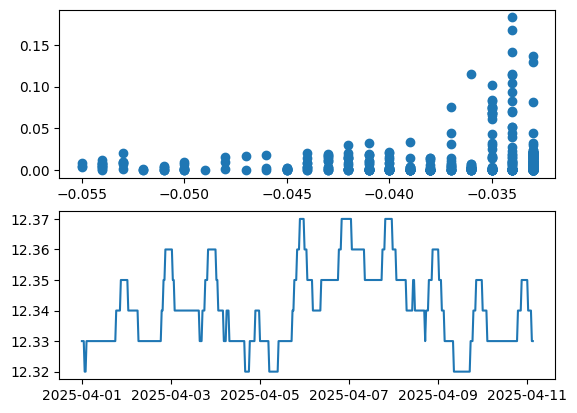

In [4]:
import matplotlib.pyplot as plt
df = d.Arrays['101']['DataFrame']#.resample('D').max()
df = df.loc[((df.index.year==2025)&(df.index.month==4))]
fig,ax=plt.subplots(2)
ax[0].scatter(df['Current_AVG'],df['SlrW_AVG'])
ax[1].plot(df['Voltage_AVG'])
# df['Voltage_AVG'].plot(ax=ax[0])
# df['Current_AVG'].plot(ax=ax[1])
# fig.autofmt_xdate()
# df[['Voltage_AVG','Current_AVG']].describe()


In [5]:
(d.Arrays['101']['variableMap'])

{'ArrayID': {'operation': 'Smp', 'dataType': 'int32', 'ignore': False},
 'Year_RTM': {'operation': 'RTM', 'dataType': 'int32', 'ignore': False},
 'Day_RTM': {'operation': 'RTM', 'dataType': 'int32', 'ignore': False},
 'Hour_Minute_RTM': {'operation': 'RTM', 'dataType': 'int32', 'ignore': False},
 'BattV_AVG': {'operation': 'AVG', 'dataType': 'float32', 'ignore': True},
 'Current_AVG': {'operation': 'AVG', 'dataType': 'float32', 'ignore': True},
 'Voltage_AVG': {'operation': 'AVG', 'dataType': 'float32', 'ignore': True},
 'NR_Wm2_AVG': {'operation': 'AVG', 'dataType': 'float32', 'ignore': True},
 'SlrW_AVG': {'operation': 'AVG', 'dataType': 'float32', 'ignore': True},
 'AirTC_AVG': {'operation': 'AVG', 'dataType': 'float32', 'ignore': True},
 'RH': {'operation': 'Smp', 'dataType': 'float32', 'ignore': True},
 'Pressure_AVG': {'operation': 'AVG', 'dataType': 'float32', 'ignore': True},
 'ITemp_C_AVG': {'operation': 'AVG', 'dataType': 'float32', 'ignore': True}}

In [6]:
%load_ext autoreload
import os
import os
import shutil
import dbPipeline
import time
from parseFiles.helperFunctions.loadDict import loadDict

In [63]:
%autoreload 2
projectPath = os.path.join(os.getcwd(),'test')
try:
    shutil.rmtree(projectPath)
except:
    pass
db = dbPipeline.database(projectPath=projectPath,verbose=False,enableParallel=True)
Sites = r'example_data\projectInventory_Template.yml'
db.projectInventory(newSites=Sites)

template = loadDict(r'example_data\source_Template.yml')
rootPath = r'example_data'
for siteID in template:
    for measurementID in template[siteID]:
        print(siteID,measurementID)
        db.rawFileSearch(siteID,measurementID,template[siteID][measurementID])

# siteID,measurementID = 'SCL','Met'
# db.rawFileSearch(siteID,measurementID,template[siteID][measurementID])

c:\Users\jskeeter\gsc-permafrost\EC_dataPipeline\dbPipeline.py line 96:
{'measurementID': 'Flux', 'description': 'High frequency (20 Hz) Eddy Covariance data', 'fileType': 'TOB3', 'sampleFrequency': '50ms', 'latitude': 69.2264167, 'longitude': -135.2519067, 'startDate': datetime.date(2024, 7, 20), 'stopDate': None, 'sourceFiles': {'*Flux*.dat': {'matchPattern': '*Flux*.dat', 'rootPath': 'c:\\Users\\jskeeter\\gsc-permafrost\\EC_dataPipeline\\example_data', 'parserSettings': {'timezone': 'UTC', 'calcStats': ['mean']}}}}

c:\Users\jskeeter\gsc-permafrost\EC_dataPipeline\dbPipeline.py line 102:
{'measurementID': 'Flux', 'description': 'High frequency (20 Hz) Eddy Covariance data', 'fileType': 'TOB3', 'sampleFrequency': '50ms', 'latitude': 69.2264167, 'longitude': -135.2519067, 'startDate': datetime.date(2024, 7, 20), 'stopDate': None, 'sourceFiles': {'*Flux*.dat': {'matchPattern': '*Flux*.dat', 'rootPath': 'c:\\Users\\jskeeter\\gsc-permafrost\\EC_dataPipeline\\example_data', 'parserSetting

In [11]:
%autoreload 2

db = dbPipeline.database(projectPath=projectPath,verbose=False,enableParallel=True)
# db.rawFileSearch('SCL','Met')

c:\Users\jskeeter\gsc-permafrost\EC_dataPipeline\dbPipeline.py line 96:
{'measurementID': 'Flux', 'description': 'High frequency (20 Hz) Eddy Covariance data', 'fileType': 'TOB3', 'sampleFrequency': '50ms', 'latitude': 69.2264167, 'longitude': -135.2519067, 'startDate': datetime.date(2024, 7, 20), 'stopDate': None, 'sourceFiles': {'*Flux*.dat': {'matchPattern': '*Flux*.dat', 'rootPath': 'c:\\Users\\jskeeter\\gsc-permafrost\\EC_dataPipeline\\example_data', 'parserSettings': {'timezone': 'UTC', 'calcStats': ['mean']}}}}

c:\Users\jskeeter\gsc-permafrost\EC_dataPipeline\dbPipeline.py line 102:
{'measurementID': 'Flux', 'description': 'High frequency (20 Hz) Eddy Covariance data', 'fileType': 'TOB3', 'sampleFrequency': '50ms', 'latitude': 69.2264167, 'longitude': -135.2519067, 'startDate': datetime.date(2024, 7, 20), 'stopDate': None, 'sourceFiles': {'*Flux*.dat': {'matchPattern': '*Flux*.dat', 'rootPath': 'c:\\Users\\jskeeter\\gsc-permafrost\\EC_dataPipeline\\example_data', 'parserSetting

SystemExit: 

c:\Users\jskeeter\gsc-permafrost\EC_dataPipeline\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3557: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [19]:
from dataclasses import dataclass

@dataclass
class test:
    a: str = 'a'

    def __post_init__(self,b=None):
        print(b)

test().__post_init__('x')

None
x


In [51]:
from dataclasses import dataclass,field,asdict

@dataclass
class a:
    a:str=field(default='a',repr=True)
    z:str=field(default='z',repr=False)

    def __post_init__(self):
        self.b = 'b'
    
    def blorb(self):
        self.chou = 'pi'

c = a()
c.blorb()
def filt(dc):
    print(dc)
    return({'a':'a'})
asdict(c,dict_factory=dict)



{'a': 'a', 'z': 'z'}

In [46]:
asdict

<function dataclasses.asdict(obj, *, dict_factory=<class 'dict'>)>

In [13]:
from parseFiles.helperFunctions.loadDict import loadDict
# importlib.reload(dbPipeline)

# db = dbPipeline.database(projectPath=projectPath,verbose=False,enableParallel=False)
template = loadDict(r'example_data\source_Template.yml')
# # sourcePath = r'U:\EC_Backup\SCL_2024\20240724'
sourcePath = r'example_data'
for siteID in template:
    for measurementID in template[siteID]:
        db.rawFileSearch(siteID,measurementID,sourcePath=sourcePath,**template[siteID][measurementID])

                     Lat           Lon            Zm    Zm_adj_Avg  LI7700_u  \
TIMESTAMP                                                                      
2024-08-19  6.922642e+01  1.352519e+02  3.285000e+00  3.225708e+00     0.230   
2024-08-20  4.202102e+06  2.356564e-41 -3.758524e+20 -7.393419e+19     0.000   
2024-08-21  4.414000e+00 -1.737500e-01  2.223001e+01  5.300000e+01     3.890   
2024-08-22 -2.124258e+20 -2.066687e+20  5.673254e+08 -3.341687e-19    69.210   
2024-08-23  2.720654e+01 -3.689349e+19  2.298023e+01  0.000000e+00     3.520   
2024-08-24  2.350398e-41  7.667264e+34 -2.713126e+19 -5.438501e+22     0.000   
2024-08-25  4.291300e+01 -4.542750e+00  3.764500e+00  8.000000e-03     4.330   
2024-08-26 -8.056948e+24 -2.212485e+24 -2.092219e+30  6.825743e+33  6891.000   
2024-08-27  2.490000e+02  5.625000e+01  2.720654e+01 -3.689349e+19     4.480   
2024-08-28  1.625482e-15  2.537838e+15  2.350398e-41  2.203338e+33     7.416   
2024-08-29  2.126890e+01  1.018210e+02  

c:\Users\jskeeter\gsc-permafrost\EC_dataPipeline\test2\database\SCL\WSM_Profile\2024\POSIX_timestamp
c:\Users\jskeeter\gsc-permafrost\EC_dataPipeline\dbPipeline.py line 208:
?

c:\Users\jskeeter\gsc-permafrost\EC_dataPipeline\dbPipeline.py line 229:
c:\Users\jskeeter\gsc-permafrost\EC_dataPipeline\test2\database\SCL\WSM_Profile\2024\_variableMap.yml



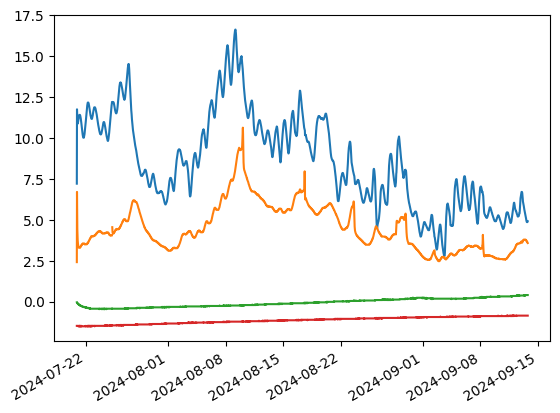

In [168]:
import numpy as np
import matplotlib.pyplot as plt
importlib.reload(dbPipeline)
path = projectPath + r'\database\SCL\Met'
path = projectPath + r'\database\SCL\WSM_Profile'
f = dbPipeline.databaseFolder(path = path,Years= 2024)
fig = plt.figure()
Data = f.dataOut
# Data.loc[((Data['AirTC_Avg']>50)|(Data['AirTC_Avg']<-60)),'AirTC_Avg']=np.nan
# plt.plot(Data['AirTC_Avg'])
plt.plot(Data['TS_1_2_1'])
plt.plot(Data['TS_2_2_1'])
plt.plot(Data['TS_3_2_1'])
plt.plot(Data['TS_4_2_1'])
fig.autofmt_xdate()

In [57]:
import matplotlib.pyplot as plt
import rawDataFile
import importlib
importlib.reload(rawDataFile)
rd = rawDataFile.TOB3(sourceFile=r'u:\EC_Backup\SCL_2024\20240912\Flux_Data495.dat')
# rd.Data['Diagnostic_CSAT']=0
rd.Data.to_csv('SCL_Data_'+rd.fileTimestamp+'.dat',index=False)
# 'Flux_Data_'+rd.fileTimestamp+'.dat'
# rd.fileTimestamp
# rd.Data.to_csv('Test.dat')
# plt.figure()
# plt.plot(rd.Data['Diagnostic_CSAT'][:-1])
rd.Data.shape


c:\Users\jskeeter\gsc-permafrost\EC_dataPipeline\rawDataFile.py line 216:
Frames 3000



(36000, 18)

In [ ]:
import configparser

ini = configparser.ConfigParser()
ini.read(r'config_files/GHG_md_template.metadata')
for s in ini.sections():
    if s != 'Files':
        for key,value in (ini[s].items()):
            ini[s][key] = ''
ini

with open(r'config_files/GHG_ep_template.metadata', 'w') as f:
    f.write(';GHG_METADATA\n')
    ini.write(f,space_around_delimiters=False)